Reference: https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements

## Setup

In [ ]:
!pip install -U langgraph langsmith langchain_anthropic

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


## Part1: Build a Basic Chatbot

**LangGraph로 Graph 정의하는 방법**
1. State 정의
    - 그래프의 State는 데이터를 저장하고 관리하는 방식(구조)을 정의한 것
    - State는 보통 TypedDict라는 형태로, 여러 키-값 쌍을 가질 수 있음. (여기서는 State가 messages라는 단일 키를 가짐)

2. Reducer 함수
    - messages라는 키는 add_messages라는 특별한 함수(리듀서 함수)가 함께 지정되어 있음
    - add_messages 함수는 messages 리스트에 새로운 항목을 추가하는 방식으로 동작 (기존의 messages 리스트를 덮어쓰지 않고 새 메시지를 리스트 끝에 추가하게 되는 것)
    - 만약 어떤 키가 리듀서 함수 없이 정의된다면, 그 키는 업데이트할 때마다 가장 최근 값으로 덮어쓰기된다.
  

**Graph 동작원리**
1. 모든 노드는 현재의 State를 입력으로 받고, 해당 State를 업데이트하는 값(출력)을 반환
2. 이 예제에서는 messages는 add_messages 함수를 사용해 값을 추가하는 방식으로 업데이트되며,
3. 이렇게 함으로써 기존 메시지가 유지되며, 새로운 메시지만 리스트에 이어 붙는 것


In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

**chatbot 노드 추가**
- 노드(node)는 실제로 작업을 수행하는 단위로, 일반적인 Python 함수처럼 작동


**챗봇 노드 함수의 동작방식**
- 챗봇 노드 함수는 현재의 State(상태)를 입력으로 받아서 처리한 후, 업데이트된 messages 리스트를 포함하는 딕셔너리를 반환
- 이 패턴은 LangGraph에서 모든 노드 함수가 따르는 기본 패턴
-  즉, 각 노드 함수는 현재 State를 참고하여 처리한 결과를 다시 State에 반영하는 구조

In [3]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model='claude-3-5-sonnet-20240620')

def chatbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**시작점 설정**
- 그래프가 실행될 때 어디서부터 시작할지를 지정

In [4]:
graph_builder.add_edge(START, "chatbot")

**끝점 설정**
- 그래프가 특정 노드에서 종료될 수 있도록 끝점(종료 지점)도 설정

In [5]:
graph_builder.add_edge("chatbot", END)

**그래프 컴파일**
- 그래프를 실행 가능하게 컴파일(compile)

In [6]:
graph = graph_builder.compile()

**그래프 시각화**

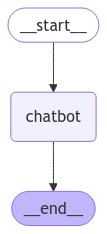

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Run Chatbot**

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value['messages'][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Goodbye !")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  안녕 내이름은 이세은


Assistant: 안녕하세요 이세은님! 만나서 반갑습니다. 저는 AI 어시스턴트입니다. 오늘 무엇을 도와드릴까요? 궁금한 점이 있으시면 언제든 물어보세요.


User:  LangGraph에 대해서 알아?


Assistant: LangGraph는 최근에 등장한 라이브러리로, 대규모 언어 모델(LLM)을 사용하여 복잡한 작업 흐름을 구성하고 관리하는 데 도움을 주는 도구입니다. 이 라이브러리는 LangChain 팀에 의해 개발되었으며, LangChain 생태계의 일부입니다.

LangGraph의 주요 특징과 개념은 다음과 같습니다:

1. 그래프 기반 접근: 복잡한 작업을 노드와 엣지로 구성된 그래프로 표현합니다.

2. 상태 관리: 작업 흐름 내에서 상태를 효과적으로 관리할 수 있습니다.

3. LLM과의 통합: 대규모 언어 모델을 작업 흐름에 쉽게 통합할 수 있습니다.

4. 유연성: 다양한 유형의 작업 흐름을 구성할 수 있어 다양한 응용 프로그램에 적용 가능합니다.

5. 재사용성: 작업 흐름의 구성 요소를 쉽게 재사용하고 조합할 수 있습니다.

LangGraph는 특히 다음과 같은 상황에서 유용합니다:

- 복잡한 대화 시스템 구축
- 다단계 추론 프로세스 구현
- 동적인 작업 흐름 관리
- AI 에이전트 시스템 개발

이 라이브러리는 아직 초기 단계에 있지만, LLM을 활용한 복잡한 시스템을 구축하는 데 있어 강력한 도구가 될 것으로 기대됩니다.


User:  q


Goodbye !


## Part2: Enhancing the Chatbot with Tools
- LangGraph로 만든 챗봇을 웹 검색 기능을 추가하여 강화하는 방법

In [ ]:
!pip install -U tavily-python langchain_community

In [9]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


**Define the tool**

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

- "What's a 'node' in LangGraph?"라는 질문에 대해 tool.invoke 메서드를 사용하면 Tavily 검색 엔진에서 관련 정보를 찾아 반환
- 검색 결과는 요약된 페이지 내용으로 제공되며, 챗봇이 답변을 생성하는 데 사용할 수 있음

**Define graph**
- Part1과 거의 동일
- 다만 bind_tools를 통해 LLM(대형 언어 모델)에 검색 도구를 연동
- 이렇게 하면 LLM이 JSON 형식으로 검색 도구를 호출하여 필요한 정보를 사용할 수 있게 된다.

In [12]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM with tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)

**도구 호출 기능에 필요한 함수 추가**
- 사용자가 요청한 검색 도구를 호출하는 새로운 노드를 추가하여, 챗봇이 필요한 경우 검색 도구를 사용할 수 있도록한다.

1. **BasicToolNode 생성하기**
   - `BasicToolNode`라는 새로운 노드를 만들어, 이 노드가 최근 메시지에서 도구 호출 요청(`tool_calls`)을 확인하도록 합니다.
   - 만약 메시지에 `tool_calls`가 포함되어 있으면, 정의된 도구를 호출해 정보를 검색합니다.
   
2. **도구 호출 지원**
   - 이 노드는 LLM(대형 언어 모델)의 도구 호출 기능을 활용해 작동합니다. Anthropic, OpenAI, Google Gemini 등 여러 LLM 제공 업체들이 이러한 도구 호출 기능을 지원합니다.

3. **LangGraph의 내장 ToolNode**
   - 이 과정을 수동으로 구현한 후에는 LangGraph에 내장된 `ToolNode`를 사용하여, 보다 빠르게 도구 호출 기능을 설정할 수 있습니다.
   - 하지만, 처음에는 직접 `BasicToolNode`를 만들어 보는 것이 학습에 도움이 되기 때문에, 먼저 수동으로 구현해보는 것입니다.

In [14]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage"""
    """마지막 AI메시지에서 요청한 도구를 실행하는 노드"""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(
                tool_call['args']
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call['name'],
                    tool_call_id=tool_call['id'],
                )
            )
        return {'messages': outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

**조건부 엣지 정의하기**

1. **엣지(Edges)란?**
   - 엣지는 그래프에서 한 노드에서 다른 노드로 제어 흐름을 이동시키는 연결입니다. 
   - **조건부 엣지**는 특정 조건을 기반으로 다음 노드로 이동하게 합니다. 일반적으로 "if" 문을 사용하여 현재 그래프 상태에 따라 다른 노드로 라우팅됩니다.

2. **라우터 함수 정의: `route_tools`**
   - **라우터 함수**는 `tool_calls`가 챗봇의 출력에 있는지 확인하고, 그에 따라 다음으로 호출할 노드를 결정합니다. 
   - 이 함수는 현재 그래프 상태를 받고, 다음에 호출할 노드의 이름을 문자열 또는 문자열 리스트로 반환합니다.

3. **조건부 엣지 추가**
   - `add_conditional_edges` 메서드를 사용하여 그래프에 이 라우터 함수를 추가합니다. 
   - 이렇게 하면 챗봇 노드가 완료될 때마다 `route_tools` 함수를 호출하여 다음 노드로 어디로 이동할지를 확인합니다.

In [15]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message has tool calls.
    Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get('messages', []):
        ai_message = messages[-1]
    else: 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The 'tools_condition' function returns "tools" if the chatbot asks to use a tool, 
# and "END" it is fine directly responding
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END}, 
    # 조건의 출력을 특정 노드로 해석하도록 지시하는 딕셔너리
    # 기본적으로 tools라는 이름의 노드로 해석되지만, 다른 이름으로도 지정할 수 있습니다.
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**흐름 및 작동 방식**

- **도구 호출 확인**: `route_tools` 함수는 챗봇의 출력에서 `tool_calls`가 있는지 검사합니다.
  - 만약 `tool_calls`가 있다면, 다음으로 도구를 호출하는 노드로 흐름을 이동시킵니다.
  - 반대로 `tool_calls`가 없다면, 흐름을 `END` 노드로 이동시킵니다. 이때 `END`는 그래프 실행의 종료를 나타냅니다.

- **미래 계획**: 나중에 `tools_condition`이라는 내장된 기능으로 이 로직을 더 간결하게 구현할 수 있지만, 처음에 직접 구현해보는 것이 이해에 도움이 됩니다

> *Note* <br>
> 조건부 에지는 단일 노드에서 시작 <br>
> 도구 호출이 이루어지지 않으면 함수는 END 문자열을 반환 <br>
> 그래프가 END로 전환되면 더 이상 완료해야 할 작업이 없고 실행이 중단 <br> 
> 조건이 END를 반환할 수 있기 때문에 이번에는 finish_point를 명시적으로 설정할 필요가 없음 <br>

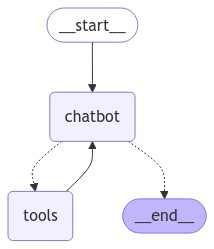

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Run Chatbot**

In [17]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  What do you know about LangGraph?


Assistant: [{'text': "To provide you with accurate and up-to-date information about LangGraph, I'll need to search for the latest details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01Axr63DNKKy8nbZw7kR23Ah', 'input': {'query': 'LangGraph AI tool information'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "Overview. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures"}, {"url": "https://www.langchain.com/langgraph", "content": "LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just wo

User:  q


Goodbye!
